##IMPORT LIBRARY

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical




##LOAD & CEK DATASET

In [ ]:
df = pd.read_csv("/content/emotions_dataset.csv")

print(df.head())
print(df.info())


                                            Sentence      Label
0  Unfortunately later died from eating tainted m...  happiness
1  Last time I saw was loooong ago. Basically bef...    neutral
2  You mean by number of military personnel? Beca...    neutral
3  Need to go middle of the road no NAME is going...    sadness
4           feel melty miserable enough imagine must    sadness
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131306 entries, 0 to 131305
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Sentence  131306 non-null  object
 1   Label     131306 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB
None


##EXPLORATORY DATA ANALYSIS (EDA)

Jumlah data: 131306
Jumlah kolom: 2

Distribusi Label:
Label
happiness    31205
sadness      17809
neutral      15733
anger        13341
love         10512
fear          8795
disgust       8407
confusion     8209
surprise      4560
shame         4248
guilt         3470
sarcasm       2534
desire        2483
Name: count, dtype: int64


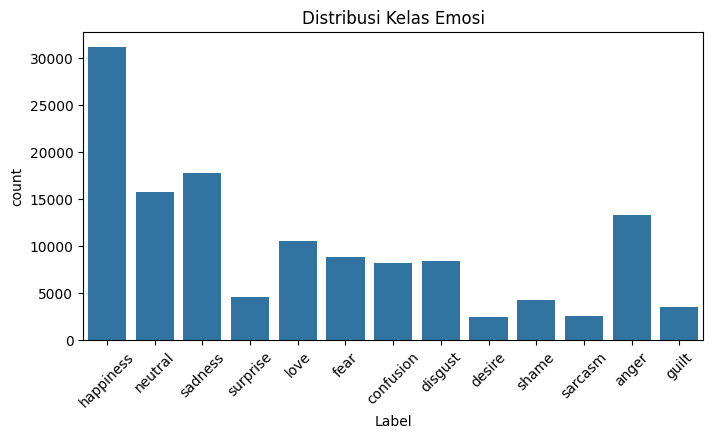

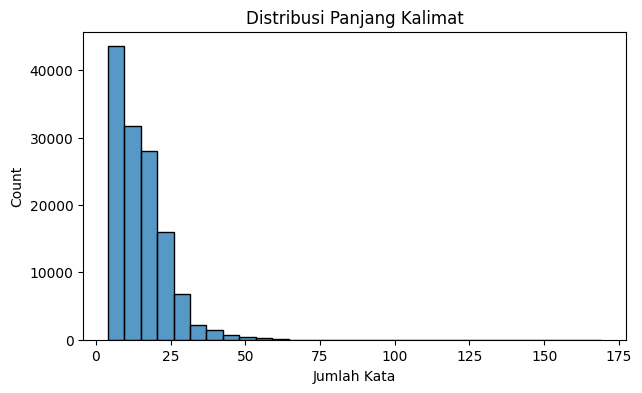

In [ ]:
print("Jumlah data:", df.shape[0])
print("Jumlah kolom:", df.shape[1])

print("\nDistribusi Label:")
print(df['Label'].value_counts())

plt.figure(figsize=(8,4))
sns.countplot(x='Label', data=df)
plt.title("Distribusi Kelas Emosi")
plt.xticks(rotation=45)
plt.show()

# Panjang teks
df['word_length'] = df['Sentence'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(7,4))
sns.histplot(df['word_length'], bins=30)
plt.title("Distribusi Panjang Kalimat")
plt.xlabel("Jumlah Kata")
plt.show()


##DATA PREPROCESSING

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    return text

df['Sentence_clean'] = df['Sentence'].apply(clean_text)

# Encode label
le = LabelEncoder()
df['Label_enc'] = le.fit_transform(df['Label'])

num_classes = df['Label_enc'].nunique()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['Sentence_clean'],
    df['Label_enc'],
    test_size=0.2,
    random_state=42,
    stratify=df['Label_enc']
)


##MODEL 1 — LSTM (NON-PRETRAINED)

In [ ]:
# Tokenisasi & Padding
MAX_WORDS = 20000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Class weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# Model LSTM
model_lstm = Sequential()

# Layer Embedding
model_lstm.add(Embedding(input_dim=20000, output_dim=128, input_length=100, input_shape=(100,)))
model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(Dropout(0.5))  # Regularisasi Dropout
model_lstm.add(LSTM(64))
model_lstm.add(Dropout(0.5))

# Output layer untuk 13 kelas dengan aktivasi softmax
model_lstm.add(Dense(13, activation='softmax'))

# Compile model untuk klasifikasi multikelas
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Ringkasan model
model_lstm.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,741,837 (10.46 MB)

 Trainable params: 2,741,837 (10.46 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

history_lstm = model_lstm.fit(
    X_train_pad,
    y_train_cat,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    class_weight=class_weight_dict
)

Epoch 1/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.1945 - loss: 2.0203 - val_accuracy: 0.4636 - val_loss: 1.5005
Epoch 2/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step - accuracy: 0.4862 - loss: 1.2386 - val_accuracy: 0.5204 - val_loss: 1.3607
Epoch 3/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 59s 40ms/step - accuracy: 0.5827 - loss: 1.0200 - val_accuracy: 0.5549 - val_loss: 1.2878
Epoch 4/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 71s 48ms/step - accuracy: 0.6237 - loss: 0.9021 - val_accuracy: 0.5359 - val_loss: 1.3604
Epoch 5/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 73s 49ms/step - accuracy: 0.6574 - loss: 0.8013 - val_accuracy: 0.5607 - val_loss: 1.3331
Epoch 6/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 74s 50ms/step - accuracy: 0.6889 - loss: 0.7153 - val_accuracy: 0.5486 - val_loss: 1.4151
Epoch 7/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 66s 40ms/step - accuracy: 0.7101 - loss: 0.6580 - val_accuracy: 0.5529 - val_loss: 1.4675
Epoch 8/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 72s 33ms/step - accuracy: 0.7303 -

821/821 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step
=== Classification Report LSTM ===
              precision    recall  f1-score   support

       anger       0.63      0.54      0.58      2668
   confusion       0.28      0.35      0.31      1642
      desire       0.70      0.85      0.77       497
     disgust       0.38      0.41      0.39      1681
        fear       0.68      0.76      0.72      1759
       guilt       0.33      0.59      0.42       694
   happiness       0.75      0.48      0.58      6241
        love       0.51      0.70      0.59      2102
     neutral       0.49      0.42      0.45      3147
     sadness       0.81      0.69      0.75      3562
     sarcasm       0.97      0.97      0.97       507
       shame       0.29      0.45      0.36       850
    surprise       0.30      0.58      0.39       912

    accuracy                           0.55     26262
   macro avg       0.55      0.60      0.56     26262
weighted avg       0.60      0.55      0.56     26262



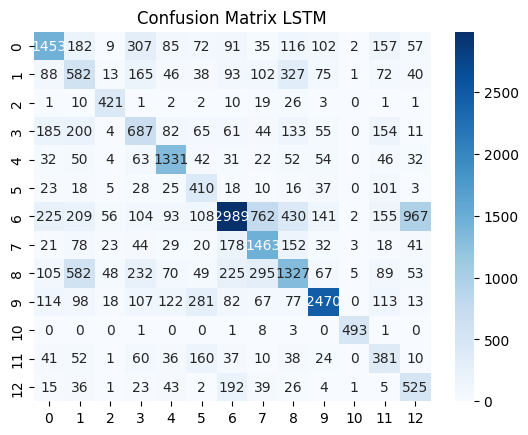

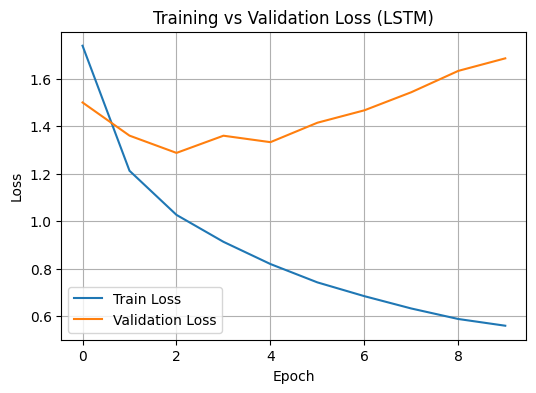

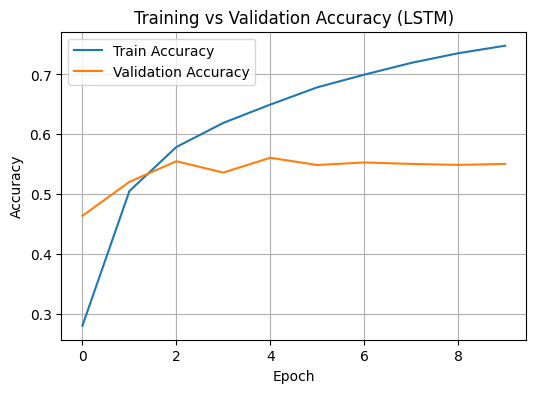

In [ ]:
# Evaluasi LSTM
y_pred_lstm = np.argmax(model_lstm.predict(X_test_pad), axis=1)

print("=== Classification Report LSTM ===")
print(classification_report(y_test, y_pred_lstm, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix LSTM")
plt.show()

# Plot training
plt.figure(figsize=(6,4))
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Simpan Model
import pickle
model_lstm.save("model_lstm.h5")

with open("history_lstm.pkl", "wb") as f:
    pickle.dump(history_lstm.history, f)
